**<center>Stock Market Trading Bot</center>**

# Table of contents

* [OHLC Data]() 
    * [Loading Data](#OHLC_Load)
    * [Plotting Data](#Plt)
    * [Descriptive Statistics](#desc)
    * [Inferential Statistics](#Inf)
    * [Trading FrameWork](#Tf)
    * [Trade Log](#Tl)
    * [Unit Testing](#Ut)
* [Per Trade Data]()
    * [Loading Data](#pt)
    * [Combining Date Time](#dt)
    * [Cleaning Data](#Clean)
    * [Data Cube](#DataCube)
    * [PortFoilio Optimization](#MPT)

# Importing libraries

In [ ]:
!pip install plotly
!pip install PyPortfolioOpt

In [1]:
import csv
import time
import math
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib as mpl
from pypfopt.cla import CLA
from pypfopt.cla import CLA
from datetime import datetime
import pypfopt.plotting as pplt
import matplotlib.pyplot as plt
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import discrete_allocation
from pypfopt import objective_functions
from matplotlib.ticker import FuncFormatter
from pypfopt.efficient_frontier import EfficientFrontier 

# Data Source

[Data Source](https://www.kaggle.com/ghazanfarali/ksedataset?select=UBL.csv) 
[Data Source](https://www.kaggle.com/arsalanjaved/pakistan-stock-exchange)

# Loading data <a name='OHLC_Load'></a>

In [ ]:
UBL=pd.read_csv('Data/UBL.csv',index_col='Date',parse_dates=True)
HBL=pd.read_csv('Data/HBL.csv',index_col='Date',parse_dates=True)
NBP=pd.read_csv('Data/NBP.csv',index_col='Date',parse_dates=True)
MEBL=pd.read_csv('Data/MEBL.csv',index_col='Date',parse_dates=True)
UBL.head()

# Plotting Data <a name='Plt'></a>

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(data=UBL.Close,label='UBL')
sns.lineplot(data=HBL.Close,label='HBL')
sns.lineplot(data=MEBL.Close,label='MEBL')
sns.lineplot(data=NBP.Close,label='NBP')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Closing Price',fontsize=15)
plt.title('Trend of Share Price of different KSE-30 Companies',fontsize=15)

## Dropping redundant feature

In [ ]:
UBL.drop('Symbol',axis=1,inplace=True)
MEBL.drop('Symbol',axis=1,inplace=True)
NBP.drop('Symbol',axis=1,inplace=True)
HBL.drop('Symbol',axis=1,inplace=True)

## Changing column names in order to facilitate merge

In [ ]:
UBL.columns=['UBL_Open','UBL_High','UBL_Low','UBL_Close','UBL_Volume']
MEBL.columns=['MEBL_Open','MEBL_High','MEBL_Low','MEBL_Close','MEBL_Volume']
HBL.columns=['HBL_Open','HBL_High','HBL_Low','HBL_Close','HBL_Volume']


## Merging Data Frame

In [ ]:
data=pd.concat([UBL,MEBL,HBL],axis=1)
data.info()

## Reversing Data Frame

In [ ]:
data1=data.iloc[::-1]
data1=data1.reset_index()
data1=data1.iloc[::-1]
data1=data1.set_index('Date')

In [ ]:
x=data1

In [ ]:
x.head()

## Dropping Missing Values

In [ ]:
data1.dropna(inplace=True)

In [ ]:
data1.isnull().sum().sum()

# Descriptive Statistics <a name='desc'></a>

In [ ]:
data2=data1.loc[:,['UBL_Close','MEBL_Close','HBL_Close']]

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(data=data2.corr())

## Box plot

In [ ]:
plt.figure(figsize=(14,10))
sns.boxplot(data=data2)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Closing Price',fontsize=15)
plt.title('Trend of Share Price of different KSE-30 Companies',fontsize=15)

# Inferential Statistics <a name='Inf'></a>

## Pearson Correlation

In [ ]:
pearson_coeff,p_val=stats.pearsonr(data2['UBL_Close'],data2['HBL_Close'])
pearson_coeff,p_val

**_Conclusion:_**

Since the p-value is <
0.001, the correlation between UBL Stock Closing Price and HBL Stock Closing Price is statistically significant, and the linear relationship is quite strong (~0.834).

In [ ]:
pearson_coeff,p_val=stats.pearsonr(data2['UBL_Close'],data2['MEBL_Close'])
pearson_coeff,p_val

**_Conclusion:_**

Since the p-value is <
0.001, the correlation between UBL Stock Closing Price and HBL Stock Closing Price is statistically significant, and the linear relationship is quite strong (~0.738).

In [ ]:
pearson_coeff,p_val=stats.pearsonr(data2['MEBL_Close'],data2['HBL_Close'])
pearson_coeff,p_val

# Trading Frame Work <a name='Tf'></a>

## Basic Trading

In [ ]:
def trader(X,nS1,nS3,share_price1,share_price2):
    Amount_Gained=((nS3*share_price2)*.1)
    Brocker_fee=((nS3*share_price2)*.1)*.3*.01
    nS3=nS3-(nS3*.1)
    X=X+Amount_Gained-Brocker_fee
    Shares_bought=(.997*Amount_Gained)/share_price1
    nS1=nS1+Shares_bought
    X=X-(.997*Amount_Gained)
    return X,nS1,nS3,Amount_Gained,-(Shares_bought*share_price1),Brocker_fee

## For Stock 1

In [ ]:
def stock1(X,nS1,nS2,nS3,pS1,pS2,pS3,share_prices,Prediction,TN,low_thres,high_thres):
    Trade_Occurred,Brocker_fee,Share1,Share2,Share3,temp1,temp2,temp3=False,0,0,0,0,0,0,0
    if (pS3/TN)>low_thres and (pS2/TN)>low_thres:
            X,nS1,nS3,temp1,temp2,temp3=trader(X,nS1,nS3,share_price[0],share_price[2])
            Share3+=temp1
            Share1+=temp2
            Brocker_fee+=temp3
            X,nS1,nS2,temp1,temp2,temp3=trader(X,nS1,nS2,share_price[0],share_price[1])
            Share2+=temp1
            Share1+=temp2
            Brocker_fee+=temp3
            Trade_Occurred=True
    elif (model2_pred>model3_pred) and (pS3/TN)>low_thres:
            X,nS1,nS3,temp1,temp2,temp3=trader(X,nS1,nS3,share_price[0],share_price[2])
            Share3+=temp1
            Share1+=temp2
            Brocker_fee+=temp3
            Trade_Occurred=True
    elif (model3_pred>model2_pred) and (pS2/TN)>low_thres:
            X,nS1,nS2,temp1,temp2,temp3=trader(X,nS1,nS2,share_price[0],share_price[1])
            Share2+=temp1
            Share1+=temp2
            Brocker_fee+=temp3
            Trade_Occurred=True
    if model2_pred<0 and (pS2/TN)>low_thres:
            X,nS1,nS2,temp1,temp2,temp3=trader(X,nS1,nS2,share_price[0],share_price[1])
            Share2+=temp1
            Share1+=temp2
            Brocker_fee+=temp3
            Trade_Occurred=True
    if model3_pred<0 and (pS3/TN)>low_thres:
            X,nS1,nS3,temp1,temp2,temp3=trader(X,nS1,nS3,share_price[0],share_price[2])   
            Share3+=temp1
            Share1+=temp2
            Brocker_fee+=temp3
            Trade_Occurred=True
    return X,nS1,nS2,nS3,Trade_Occurred,Share1,Share2,Share3,Brocker_fee

## For Stock 2

In [ ]:
def stock2(X,nS1,nS2,nS3,pS1,pS2,pS3,share_prices,Prediction,TN,low_thres,high_thres):
    Trade_Occurred,Brocker_fee,Share1,Share2,Share3,temp1,temp2,temp3=False,0,0,0,0,0,0,0
    if (pS3/TN)>low_thres and (pS2/TN)>low_thres:
            X,nS2,nS3,temp1,temp2,temp3=trader(X,nS2,nS3,share_price[1],share_price[2])
            Share3+=temp1
            Share2+=temp2
            Brocker_fee+=temp3
            X,nS2,nS1,temp1,temp2,temp3=trader(X,nS2,nS1,share_price[1],share_price[0])
            Share1+=temp1
            Share2+=temp2
            Brocker_fee+=temp3
            Trade_Occurred=True
    elif (model1_pred>model3_pred) and (pS3/TN)>low_thres:
            X,nS2,nS3,temp1,temp2,temp3=trader(X,nS2,nS3,share_price[1],share_price[2])
            Share3+=temp1
            Share2+=temp2
            Brocker_fee+=temp3
            Trade_Occurred=True
    elif (model3_pred>model2_pred) and (pS1/TN)>low_thres:
            X,nS2,nS1,temp1,temp2,temp3=trader(X,nS2,nS1,share_price[1],share_price[0])
            Share1+=temp1
            Share2+=temp2
            Brocker_fee+=temp3
            Trade_Occurred=True
    if model1_pred<0 and (pS1/TN)>low_thres:
            X,nS2,nS1,temp1,temp2,temp3=trader(X,nS2,nS1,share_price[1],share_price[0])
            Share1+=temp1
            Share2+=temp2
            Brocker_fee+=temp3
            Trade_Occurred=True
    if model3_pred<0 and (pS3/TN)>low_thres:
            X,nS2,nS3,temp1,temp2,temp3=trader(X,nS2,nS3,share_price[1],share_price[2])
            Share3+=temp1
            Share2+=temp2
            Brocker_fee+=temp3
            Trade_Occurred=True
    return X,nS1,nS2,nS3,Trade_Occurred,Share1,Share2,Share3,Brocker_fee    

## For Stock 3

In [ ]:
def stock3(X,nS1,nS2,nS3,pS1,pS2,pS3,share_prices,Prediction,TN,low_thres,high_thres):
    Trade_Occurred,Brocker_fee,Share1,Share2,Share3,temp1,temp2,temp3=False,0,0,0,0,0,0,0
    if (pS3/TN)>low_thres and (pS2/TN)>low_thres:
        X,nS3,nS1,temp1,temp2,temp3=trader(X,nS3,nS1,share_price[2],share_price[0])
        Share1+=temp1
        Share3+=temp2
        Brocker_fee+=temp3
        X,nS3,nS2,temp1,temp2,temp3=trader(X,nS3,nS2,share_price[2],share_price[1])
        Share2+=temp1
        Share3+=temp2
        Brocker_fee+=temp3
        Trade_Occurred=True
    elif (model2_pred>model1_pred) and (pS1/TN)>low_thres:
        X,nS3,nS1,temp1,temp2,temp3=trader(X,nS3,nS1,share_price[2],share_price[0])
        Share1+=temp1
        Share3+=temp2
        Brocker_fee+=temp3
        Trade_Occurred=True
    elif (model1_pred>model2_pred) and (pS2/TN)>low_thres:
        X,nS3,nS2,temp1,temp2,temp3=trader(X,nS3,nS2,share_price[2],share_price[1])
        Share2+=temp1
        Share3+=temp2
        Brocker_fee+=temp3
        Trade_Occurred=True
    if model2_pred<0 and (pS2/TN)>low_thres:
        X,nS3,nS2,temp1,temp2,temp3=trader(X,nS3,nS2,share_price[2],share_price[1])
        Share2+=temp1
        Share3+=temp2
        Brocker_fee+=temp3
        Trade_Occurred=True
    if model1_pred<0 and (pS1/TN)>low_thres:
        X,nS3,nS1,temp1,temp2,temp3=trader(X,nS3,nS1,share_price[2],share_price[0])
        Share1+=temp1
        Share3+=temp2
        Brocker_fee+=temp3
        Trade_Occurred=True
    return X,nS1,nS2,nS3,Trade_Occurred,Share1,Share2,Share3,Brocker_fee

## Making Trades

In [ ]:
def shares_trading(X,nS1,nS2,nS3,share_prices,Prediction,TN,low_thres,high_thres):
    model1_pred,model2_pred,model3_pred=Prediction[0],Prediction[1],Prediction[2]
    pS1,pS2,pS3=(nS1*share_prices[0]),(nS2*share_prices[1]),(nS3*share_prices[2])
    Trade_Occurred,Brocker_fee,Share1,Share2,Share3=False,0,0,0,0
    if (model1_pred>model2_pred and model1_pred>model3_pred) and (pS1/TN)<high_thres:
        X,nS1,nS2,nS3,Trade_Occurred,Share1,Share2,Share3,Brocker_fee=stock1(X,nS1,nS2,nS3,pS1,pS2,pS3,
                                                                      share_prices,Prediction,TN,
                                                                      low_thres,high_thres)
        return X,nS1,nS2,nS3,Trade_Occurred,Share1,Share2,Share3,Brocker_fee
    
    elif (model2_pred>model1_pred and model2_pred>model3_pred) and (pS2/TN)<high_thres:
        X,nS1,nS2,nS3,Trade_Occurred,Share1,Share2,Share3,Brocker_fee=stock2(X,nS1,nS2,nS3,pS1,pS2,pS3,
                                                                      share_prices,Prediction,TN,
                                                                      low_thres,high_thres)
        return X,nS1,nS2,nS3,Trade_Occurred,Share1,Share2,Share3,Brocker_fee
    elif (model3_pred>model1_pred and model3_pred>model2_pred) and (pS3/TN)<high_thres:
        X,nS1,nS2,nS3,Trade_Occurred,Share1,Share2,Share3,Brocker_fee=stock3(X,nS1,nS2,nS3,pS1,pS2,pS3,
                                                                      share_prices,Prediction,TN,
                                                                      low_thres,high_thres)
        return X,nS1,nS2,nS3,Trade_Occurred,Share1,Share2,Share3,Brocker_fee
    else:
        Amount_Gained,Brocker_Fee=0,0
        return X,nS1,nS2,nS3,Trade_Occurred,Share1,Share2,Share3,Brocker_fee


## Front End of Trading Framework

In [ ]:
%matplotlib notebook
plt.rcParams['animation.html']='jshtml'

In [ ]:
data1.index=data1.index.astype('str')
fig=plt.figure(figsize=(10,6))
ax=fig.add_subplot(111)
i=0
x,y=[],[]
x1,y1=[],[]
x2,y2=[],[]
while True:
    x.append(data1.index[i])
    y.append(data1.UBL_Close[i])
    x1.append(data1.index[i])
    y1.append(data1.HBL_Close[i])
    x2.append(data1.index[i])
    y2.append(data1.MEBL_Close[i])
    ax.plot(x,y,color='blue')
    ax.plot(x1,y1,color='green')
    ax.plot(x2,y2,color='purple')
    plt.xticks(rotation=90)
    ax.legend(['UBL','HBL','MEBL'],loc='upper left')
    ax.set_xlabel('Date')
    ax.set_ylabel('Stock_Price')
    ax.set_title('Variations of Stock Prices over time')
    plt.show()
    fig.canvas.draw()
    time.sleep(1)
    i+=1

# Testing Phase

In [ ]:
data3=data1.reset_index()
data3=data3.loc[0:,:]
data3.reset_index(inplace=True)
data3.drop('index',inplace=True,axis=1)
data3

## Creating Data Frame to Trade log into Excel Sheet

In [ ]:
Data_Acquired=pd.DataFrame({'Time_Stamp':['2009-06-18','2009-06-18'],'UBL_Shares':[0,162],'HBL_Shares':[0,92],'MEBL_Shares':[0,986],'Trade_Ocurred':[False,True],
                            'UBL_Pred':[0,0],'HBL_Pred':[0,0],'MEBL_Pred':[0,0],'UBL_portfolio':[0,.33],
                            'HBL_portfolio':[0,.33],'MEBL_portfolio':[0,.33],'Balance':[100000,109],'Brocker_Fee':[0,(99000*.3*.01*3)]
                            ,'Share1_NetChange':[0,-33000],'Share2_NetChange':[0,-33000],'Share3_NetChange':[0,-33000],'TN':[100000,99109]})
Data_Acquired['Time_Stamp']=pd.to_datetime(Data_Acquired['Time_Stamp'],format='%Y-%m-%d')
Data_Acquired.to_csv('Trade_log.csv',index=None)

In [ ]:
Data_Acquired

## Unit Testing <a name='Ut'></a>

In [ ]:
X=100000
nS1=math.floor((X*.33)/data3.loc[0,'UBL_Close'])
nS2=math.floor((X*.33)/data3.loc[0,'HBL_Close'])
nS3=math.floor((X*.33)/data3.loc[0,'MEBL_Close'])
X-=X*.99+(891)
X,nS1,nS2,nS3

In [ ]:
X=100000
nS1=(X*.33)/data3.loc[0,'UBL_Close']
nS2=(X*.33)/data3.loc[0,'HBL_Close']
nS3=(X*.33)/data3.loc[0,'MEBL_Close']

X-=X*.99+(891)
low_thres=0.3
high_thres=0.4
for index in range(data3.shape[0]-1):
    total_shares=nS1+nS2+nS3
    model1_pred=data3.loc[index+1,'UBL_Close']-data3.loc[index,'UBL_Close']
    model2_pred=data3.loc[index+1,'HBL_Close']-data3.loc[index,'HBL_Close']
    model3_pred=data3.loc[index+1,'MEBL_Close']-data3.loc[index,'MEBL_Close']
    prediction=[model1_pred,model2_pred,model3_pred]
    
    share_price=[data3.loc[index,'UBL_Close'],data3.loc[index,'HBL_Close'],data3.loc[index,'MEBL_Close']]
    TN=(nS1*data3.loc[index,'UBL_Close'])+(nS2*data3.loc[index,'HBL_Close'])+(nS3*data3.loc[index,'MEBL_Close'])
    
    X,nS1,nS2,nS3,Trade_Occurred,Share1,Share2,Share3,Brocker_fee=shares_trading(X,nS1,nS2,nS3,
                                                                          share_price,prediction,TN,low_thres,
                                                                          high_thres)
    
    pS1,pS2,pS3=(nS1*data3.loc[index,'UBL_Close']),(nS2*data3.loc[index,'HBL_Close']),(nS3*data3.loc[index,'MEBL_Close'])
    TN=X+(nS1*data3.loc[index,'UBL_Close'])+(nS2*data3.loc[index,'HBL_Close'])+(nS3*data3.loc[index,'MEBL_Close'])


    with open('Trade_log.csv','a',newline='') as raw:
        file_writer=csv.writer(raw)
        file_writer.writerow([data3.loc[index,'Date'],math.floor(nS1),math.floor(nS2),math.floor(nS3),Trade_Occurred,model1_pred,model2_pred,model3_pred,
                              pS1/TN,pS2/TN,pS3/TN,X,Brocker_fee,Share1,Share2,Share3,TN])

## Trade Log <a name='Tl'></a>

In [290]:
d=pd.read_csv('Trade_log.csv')
d

,Time_Stamp,UBL_Shares,HBL_Shares,MEBL_Shares,Trade_Ocurred,UBL_Pred,HBL_Pred,MEBL_Pred,UBL_portfolio,HBL_portfolio,MEBL_portfolio,Balance,Brocker_Fee,Share1_NetChange,Share2_NetChange,Share3_NetChange,TN
0,2009-06-18,0,0,0,False,0.00,0.00,0.00,0.000000,0.000000,0.000000,100000.0,0.000000,0.000000,0.0,0.000000,100000.000000
1,2009-06-18,162,92,986,True,0.00,0.00,0.00,0.330000,0.330000,0.330000,109.0,891.000000,-33000.000000,-33000.0,-33000.000000,99109.000000
2,2007-07-16 00:00:00,146,75,1271,True,0.05,-13.60,0.50,0.299757,0.269781,0.429362,109.0,28.710000,3300.000000,6270.0,-9541.290000,99080.290000
3,2007-07-17 00:00:00,146,75,1271,False,-8.00,-17.05,-1.45,0.300988,0.260447,0.437461,109.0,0.000000,0.000000,0.0,0.000000,98699.478260
4,2007-07-18 00:00:00,167,75,1144,True,2.50,-15.85,-0.65,0.345990,0.258741,0.394114,109.0,12.399928,-4120.909265,0.0,4133.309193,94388.461874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2878,2019-08-23 00:00:00,2808,2249,3653,True,-1.32,-2.13,-2.42,0.402489,0.288668,0.308724,109.0,199.874373,-66424.916688,0.0,66624.791061,920017.934762
2879,2019-08-26 00:00:00,2808,2249,3653,False,2.00,-2.40,-1.30,0.406114,0.288905,0.304860,109.0,0.000000,0.000000,0.0,0.000000,902677.498377
2880,2019-08-27 00:00:00,2808,2249,3653,False,2.70,-0.28,2.50,0.414417,0.284352,0.301110,109.0,0.000000,0.000000,0.0,0.000000,898145.863480
2881,2019-08-28 00:00:00,2527,2249,4148,True,-2.51,-2.51,-1.23,0.373924,0.278694,0.347263,109.0,113.936901,37978.966881,0.0,-37865.029980,914118.968330


In [ ]:
TN

In [ ]:
pS1/100000,pS2/100000,pS3/100000

## Investment Portfolio

In [ ]:
total_shares=nS1+nS2+nS3
X,nS1/total_shares,nS2/total_shares,nS3/total_shares

# Per Trade Data <a name='pt'></a>

In [ ]:
Names=['ATRL','bahl','EPCL','FCCL','LUCK','MCB','MLCF','NETSOL','NML',
      'OGDC','PPL','PSO','SEARL','TRG']
i,dataframes=0,[]
for name in Names:
    dataframes.append(pd.read_csv('../per_trade_data/'+name+'.txt',delimiter='|',index_col='TRADE_ENTRY_DATE',
                        parse_dates=True))
    dataframes[i].reset_index(inplace=True)
    i+=1

In [ ]:
dataframes

# Improving DateTime Format <a name='dt'></a>

## Helper functions

In [ ]:
def Format(t):
    return t[:1]+':'+t[1:3]+':'+t[3:5]+'.'+t[5:] if len(t)==9 else t[:2]+':'+t[2:4]+':'+t[4:6]+'.'+t[6:]


In [ ]:
def Combined(date,time):
    return date[:11]+Format(str(time))

In [ ]:
def Formated(row):
    return Combined(str(row.TRADE_ENTRY_DATE),str(row.KATS_TIME))


## Applying Helper Function to improve datetime format

In [ ]:
Names=['ATRL','bahl','EPCL','FCCL','LUCK','MCB','MLCF','NETSOL','NML',
      'OGDC','PPL','PSO','SEARL','TRG']
i,dataframes=0,[]
for i in range(14):
    dataframes[i]['Date_Time']=dataframes[i].apply(Formated,axis='columns')
    dataframes[i]['Date_Time']=pd.to_datetime(dataframes[i]['Date_Time'], infer_datetime_format=True)
    dataframes[i].to_csv('../Modified_Data/Modified_'+Names[i]+'.csv',index='Date_Time')

In [ ]:
df=pd.read_csv('../Modified_Data/Modified_ATRL.csv',parse_dates=True,index_col='Date_Time',infer_datetime_format=True)
df.drop(['Unnamed: 0','KATS_TIME'],axis=1,inplace=True)
df.columns=['TRADE_ENTRY_DATE','ATRL','TRADE_QTY','TRADE_RATE']

In [ ]:
df.reset_index(inplace=True)

# Cleaning Data and completing missing values <a name='Clean'></a>

## Loading Data

In [ ]:
Names=['bahl','EPCL','FCCL','LUCK','MCB','MLCF','NETSOL','NML',
      'OGDC','PPL','PSO','SEARL','TRG']
df=pd.read_csv('../Modified_Data/Modified_ATRL.csv',parse_dates=True,index_col='Date_Time',infer_datetime_format=True)
df.drop(['Unnamed: 0','KATS_TIME'],axis=1,inplace=True)
df.reset_index(inplace=True)
for i in range(len(Names)):
    df1=pd.read_csv('../Modified_Data/Modified_'+Names[i]+'.csv',parse_dates=True,index_col='Date_Time',infer_datetime_format=True)
    df1.drop(['Unnamed: 0','KATS_TIME'],axis=1,inplace=True)
    df1.reset_index(inplace=True)
    df1.columns=[Names[i]+'_DT',Names[i]+'_TRADE_DATE',Names[i],Names[i]+'_TRADE_QTY',Names[i]+'_TRADE_RATE']
    df=pd.concat([df,df1],axis=1)


In [ ]:
df.head()

## Dropping Unnecessary features

In [ ]:
df.drop(['bahl_DT','EPCL_DT','FCCL_DT','LUCK_DT','MCB_DT','MLCF_DT','NETSOL_DT','NML_DT','OGDC_DT','PPL_DT',
        'OGDC_DT','PPL_DT','PSO_DT','SEARL_DT','TRG_DT'],axis=1,inplace=True)
df.drop(['bahl_TRADE_DATE','EPCL_TRADE_DATE','FCCL_TRADE_DATE','LUCK_TRADE_DATE','MCB_TRADE_DATE','MLCF_TRADE_DATE',
         'NETSOL_TRADE_DATE','NML_TRADE_DATE','OGDC_TRADE_DATE','PPL_TRADE_DATE',
        'OGDC_TRADE_DATE','PPL_TRADE_DATE','PSO_TRADE_DATE','SEARL_TRADE_DATE','TRG_TRADE_DATE'],axis=1,inplace=True)
df.head()

## Completing ID

In [ ]:
df.bahl.fillna('BAHL',inplace=True),df.EPCL.fillna('EPCL',inplace=True),df.FCCL.fillna('FCCL',inplace=True),
df.LUCK.fillna('LUCK',inplace=True),df.MCB.fillna('MCB',inplace=True),
df.MLCF.fillna('MLCF',inplace=True),df.NETSOL.fillna('NETSOL',inplace=True),df.NML.fillna('NML',inplace=True),
df.OGDC.fillna('OGDC',inplace=True),df.PPL.fillna('PPL',inplace=True),
df.PSO.fillna('PSO',inplace=True),df.SEARL.fillna('SEARL',inplace=True),df.TRG.fillna('TRG',inplace=True)
df.head()

## Filling the missing values

In [ ]:
for i in range(10):
    df.fillna(method ='bfill',inplace=True)
    df.fillna(method ='ffill',inplace=True)


## Fetching 

In [ ]:
Names=['ATRL','bahl','EPCL','FCCL','LUCK','MCB','MLCF','NETSOL','NML',
      'OGDC','PPL','PSO','SEARL','TRG']
df_ATRL=df.iloc[:,[0,1,2,3,4]]
df_BAHL=df.iloc[:,[0,1,5,6,7]]
df_EPCL=df.iloc[:,[0,1,8,9,10]]
df_FCCL=df.iloc[:,[0,1,11,12,13]]
df_LUCK=df.iloc[:,[0,1,14,15,16]]
df_MCB=df.iloc[:,[0,1,17,18,19]]
df_MLCF=df.iloc[:,[0,1,20,21,22]]
df_NETSOL=df.iloc[:,[0,1,23,24,25]]
df_NML=df.iloc[:,[0,1,26,27,28]]
df_OGDC=df.iloc[:,[0,1,29,30,31]]
df_PPL=df.iloc[:,[0,1,32,33,34]]
df_PSO=df.iloc[:,[0,1,35,36,37]]
df_SEARL=df.iloc[:,[0,1,38,39,40]]
df_TRG=df.iloc[:,[0,1,41,42,43]]
dataframes=[df_ATRL,df_BAHL,df_EPCL,df_FCCL,df_LUCK,df_MCB,df_MLCF,df_NETSOL,df_NML,df_OGDC,df_PPL,df_PSO,df_SEARL,
           df_TRG]

## Saving Cleaned data

In [ ]:
Names=['ATRL','bahl','EPCL','FCCL','LUCK','MCB','MLCF','NETSOL','NML',
      'OGDC','PPL','PSO','SEARL','TRG']
i=0
for i in range(14):
    dataframes[i].to_csv('../Cleaned_Data/'+Names[i]+'.csv',index='Date_Time')

# DataCubes  <a name='DataCube'></a>

## Loading all the data into Frame

In [ ]:
df=pd.read_csv('../Cleaned_Data/ATRL.csv',parse_dates=True,index_col='Date_Time',infer_datetime_format=True)
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.columns=['TRADE_ENTRY_DATE','ID','TRADE_QTY','TRADE_RATE']
df.reset_index(inplace=True)

df1=pd.read_csv('../Cleaned_Data/bahl.csv',parse_dates=True,index_col='Date_Time',infer_datetime_format=True)
df1.drop(['Unnamed: 0'],axis=1,inplace=True)
df1.columns=['TRADE_ENTRY_DATE','ID','TRADE_QTY','TRADE_RATE']
df1.reset_index(inplace=True)
df=pd.concat([df,df1])

Names=['EPCL','FCCL','LUCK','MCB','MLCF','NETSOL','NML',
      'OGDC','PPL','PSO','SEARL','TRG']
print('Into First loop')

for i in range(0,len(Names)):
    print('Into ',Names[i])
    df1=pd.read_csv('../Cleaned_Data/'+Names[i]+'.csv',parse_dates=True,index_col='Date_Time',infer_datetime_format=True)
    df1.drop(['Unnamed: 0'],axis=1,inplace=True)
    df1.columns=['TRADE_ENTRY_DATE','ID','TRADE_QTY','TRADE_RATE']
    df1.reset_index(inplace=True)
    df=pd.concat([df,df1])
    print('done ',Names[i])
df

## Grouping data to form datacube

In [ ]:
df1=df[:]
df2=df1.groupby([df1.TRADE_ENTRY_DATE,df1.Date_Time.hour,df1.Date_Time.minute,df1.SYMBOL_CODE]).TRADE_RATE.agg(['max','min'])
df2['TRADE_RATE']=df1.groupby([df1.TRADE_ENTRY_DATE,df1.Date_Time.hour,df1.Date_Time.minute]).TRADE_RATE.first()
df2.columns=['HIGH','LOW','OPEN']
df2.head()

In [ ]:
df1=df[:]
df2=df1.groupby([df1.TRADE_ENTRY_DATE,df1.Date_Time.dt.hour,df1.Date_Time.dt.minute,df1.ID]).TRADE_RATE.agg(['min','max'])
df2['OPEN']=df1.groupby([df1.TRADE_ENTRY_DATE,df1.Date_Time.dt.hour,df1.Date_Time.dt.minute,df1.ID]).TRADE_RATE.first()
df2['CLOSE']=df1.groupby([df1.TRADE_ENTRY_DATE,df1.Date_Time.dt.hour,df1.Date_Time.dt.minute,df1.ID]).TRADE_RATE.last()
df2.columns=['LOW','HIGH','OPEN','CLOSE']

## Saving DataCube

In [ ]:
df2.to_csv('File.csv')
df2

# Port FOlio Optimization

## Loading Data

In [2]:
df=pd.read_csv('../DataCube/File.csv')
df.head()

,TRADE_ENTRY_DATE,Date_Time,Date_Time.1,ID,LOW,HIGH,OPEN,CLOSE
0,2009-04-01,9,30,ATRL,82.00,83.50,82.00,82.90
1,2009-04-01,9,30,BAHL,26.14,27.30,26.92,26.50
2,2009-04-01,9,30,EPCL,22.40,23.25,22.40,22.75
3,2009-04-01,9,30,FCCL,6.41,6.74,6.49,6.70
4,2009-04-01,9,30,LUCK,50.11,51.85,50.79,51.35


## Rearranging

In [3]:
columns_titles = ['TRADE_ENTRY_DATE','DATE_Time','DATE_TIME.1','ID','OPEN','HIGH','LOW','CLOSE']
df=df.reindex(columns=columns_titles)

## Overview of Markowitz Portfolio Theory

Modern portfolio theory (MPT), or mean-variance analysis, is a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk. It is a formalization and extension of diversification in investing, the idea that owning different kinds of financial assets is less risky than owning only one type. Its key insight is that an asset's risk and return should not be assessed by itself, but by how it contributes to a portfolio's overall risk and return. It uses the variance of asset prices as a proxy for risk.

Economist Harry Markowitz introduced MPT in a 1952 essay, for which he was later awarded a Nobel Prize in Economics; see Markowitz model. 

## Prepraring Files for MPT

In [20]:
dataframes=[]
for i in range(14):
    df1=df.loc[i::14]
    dataframes.append(df1)


In [23]:
Names=['ATRL','bahl','EPCL','FCCL','LUCK','MCB','MLCF','NETSOL','NML',
      'OGDC','PPL','PSO','SEARL','TRG']
i=0
for i in range(14):
    dataframes[i].to_csv('../MPT Data/'+Names[i]+'.csv',index=None)

In [52]:
df=pd.read_csv('../MPT Data/ATRL.csv')
df.drop(['ID','OPEN','HIGH','LOW','DATE_Time','DATE_TIME.1'],axis=1,inplace=True)
df.columns=['TRADE_ENTRY_DATE','ATRL_CLOSE']

Names=['bahl','EPCL','FCCL','LUCK','MCB','MLCF','NETSOL','NML',
      'OGDC','PPL','PSO','SEARL','TRG']

for i in range(len(Names)):
    df1=pd.read_csv('../MPT Data/'+Names[i]+'.csv')
    df1.drop(['TRADE_ENTRY_DATE','ID','OPEN','HIGH','LOW','DATE_Time','DATE_TIME.1'],axis=1,inplace=True)
    df1.columns=[Names[i]+'_TRADE_RATE']
    df=pd.concat([df,df1],axis=1)
df.drop('TRADE_ENTRY_DATE',axis=1)

,TRADE_ENTRY_DATE,ATRL_CLOSE,bahl_TRADE_RATE,EPCL_TRADE_RATE,FCCL_TRADE_RATE,LUCK_TRADE_RATE,MCB_TRADE_RATE,MLCF_TRADE_RATE,NETSOL_TRADE_RATE,NML_TRADE_RATE,OGDC_TRADE_RATE,PPL_TRADE_RATE,PSO_TRADE_RATE,SEARL_TRADE_RATE,TRG_TRADE_RATE
0,2009-04-01,82.90,26.50,22.75,6.70,51.35,144.00,5.00,17.40,31.01,73.85,176.75,200.80,64.05,1.37
1,2009-04-01,83.30,26.58,23.00,6.70,51.25,144.17,4.98,17.45,31.30,74.00,177.00,200.99,64.00,1.40
2,2009-04-01,85.00,26.90,22.90,6.75,51.50,144.49,5.05,17.40,31.20,73.70,177.30,201.03,63.10,1.38
3,2009-04-01,85.40,27.02,23.19,6.70,51.85,145.00,5.08,17.50,31.05,73.80,177.33,201.12,60.80,1.31
4,2009-04-01,86.85,28.10,23.11,6.74,51.85,145.00,5.17,17.26,30.80,73.70,176.80,201.45,62.00,1.40


## Saving File

In [56]:
df.to_csv('../MPT Data/Combined.csv')

## Loading Data

In [3]:
df=pd.read_csv('../MPT Data/Combined.csv')
df.drop(['TRADE_ENTRY_DATE','Unnamed: 0'],axis=1,inplace=True)
df.head()

,ATRL_CLOSE,bahl_TRADE_RATE,EPCL_TRADE_RATE,FCCL_TRADE_RATE,LUCK_TRADE_RATE,MCB_TRADE_RATE,MLCF_TRADE_RATE,NETSOL_TRADE_RATE,NML_TRADE_RATE,OGDC_TRADE_RATE,PPL_TRADE_RATE,PSO_TRADE_RATE,SEARL_TRADE_RATE,TRG_TRADE_RATE
0,82.90,26.50,22.75,6.70,51.35,144.00,5.00,17.40,31.01,73.85,176.75,200.80,64.05,1.37
1,83.30,26.58,23.00,6.70,51.25,144.17,4.98,17.45,31.30,74.00,177.00,200.99,64.00,1.40
2,85.00,26.90,22.90,6.75,51.50,144.49,5.05,17.40,31.20,73.70,177.30,201.03,63.10,1.38
3,85.40,27.02,23.19,6.70,51.85,145.00,5.08,17.50,31.05,73.80,177.33,201.12,60.80,1.31
4,86.85,28.10,23.11,6.74,51.85,145.00,5.17,17.26,30.80,73.70,176.80,201.45,62.00,1.40


## Type Conversion

In [4]:
for _,columns in enumerate(df):
    df[[columns]]=df[[columns]].astype('float')
df.columns=['ATRL','bahl','EPCL','FCCL','LUCK','MCB','MLCF','NETSOL','NML',
      'OGDC','PPL','PSO','SEARL','TRG']


# Markowitz Model

We will move ahead with the calculations for the optimization of the portfolio. Start with capturing the expected return and the variance of the portfolio chosen.

## Base Markowitz model

In [158]:
df1=df[:20]
#Annualized Return
mu = expected_returns.mean_historical_return(df1)
#Sample Variance of Portfolio
Sigma = risk_models.exp_cov(df1)

Proceed by computing and storing the values for a portfolio weight with maximum Sharpe ratio and minimum volatility respectively.

### Calculating Optimal Portfolio

In [159]:
#Max Sharpe Ratio - Tangent to the EF
#THis means we cant hold an asset less then 5% and upper limited is calculated itself which is never greater then 35
ef = EfficientFrontier(mu, Sigma,weight_bounds=(0.05,1)) 
sharpe_pfolio=ef.max_sharpe() #May use add objective to ensure minimum zero weighting to individual stocks
sharpe_pwt=ef.clean_weights()
print(sharpe_pwt)

OrderedDict([('ATRL', 0.05), ('bahl', 0.22897), ('EPCL', 0.05), ('FCCL', 0.05), ('LUCK', 0.05), ('MCB', 0.05), ('MLCF', 0.05), ('NETSOL', 0.05), ('NML', 0.05), ('OGDC', 0.05), ('PPL', 0.05), ('PSO', 0.05), ('SEARL', 0.05), ('TRG', 0.17103)])


### Auto allocating shares based upon portfolio

In [160]:
latest_prices = discrete_allocation.get_latest_prices(df1)

allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(sharpe_pwt, latest_prices,
                                                                   total_portfolio_value=10000).lp_portfolio()

print(allocation_minv)
print("Leftover Fund value in$ after building minimum volatility portfolio is ${:.2f}".format(rem_minv))

{'ATRL': 6, 'bahl': 75, 'EPCL': 21, 'FCCL': 72, 'LUCK': 10, 'MCB': 4, 'MLCF': 95, 'NETSOL': 29, 'NML': 16, 'OGDC': 7, 'PPL': 3, 'PSO': 2, 'SEARL': 10, 'TRG': 1082}
Leftover Fund value in$ after building minimum volatility portfolio is $0.58


### Portfolio returns

In [161]:
ef.portfolio_performance(verbose=True, risk_free_rate = 0.27)

Expected annual return: 211.3%
Annual volatility: 11.1%
Sharpe Ratio: 16.55


(2.113270201996857, 0.11138704774214184, 16.548335191215234)

This will provide you the weight of different holdings. In case you want to minimize ‘zero’ holding or weight feel free to use L2 regression. Additionally, the weight_bounds have been set from -1 to 1 for allowing computation of ‘shorting’ stocks. The same exercise will be undertaken for the minimum variance portfolio.

## Plotting the Efficient Frontier and Optimizing Portfolio Allocation

The final step is the plot the efficient frontier for visual purposes, and calculate the asset allocation (i.e. no of shares to purchase or short) for a given dollar amount of a portfolio. For the purpose of this exercise, I have considered $10,000 — the default starting value on investopedia.
Image for post

## At Minimum Volatility

In [162]:
#Min Volatility Portfolio
ef1 = EfficientFrontier(mu, Sigma, weight_bounds=(0.05,1)) #weight bounds in negative allows shorting of stocks
minvol=ef1.min_volatility()
minvol_pwt=ef1.clean_weights()
print(minvol_pwt)

OrderedDict([('ATRL', 0.05), ('bahl', 0.05), ('EPCL', 0.08523), ('FCCL', 0.05), ('LUCK', 0.05), ('MCB', 0.05), ('MLCF', 0.09131), ('NETSOL', 0.27345), ('NML', 0.05), ('OGDC', 0.05), ('PPL', 0.05), ('PSO', 0.05), ('SEARL', 0.05), ('TRG', 0.05)])


### Auto Calculating 

In [163]:
# Allocate Portfolio Value in $ as required to show number of shares/stocks to buy, also bounds for shorting will affect allocation
#Min Volatility Portfolio Allocation $10000
latest_prices = discrete_allocation.get_latest_prices(df1)

allocation_minv, rem_minv = discrete_allocation.DiscreteAllocation(minvol_pwt, latest_prices,
                                                                   total_portfolio_value=10000).lp_portfolio()

print(allocation_minv)
print("Leftover Fund value in$ after building minimum volatility portfolio is ${:.2f}".format(rem_minv))

{'ATRL': 6, 'bahl': 16, 'EPCL': 36, 'FCCL': 73, 'LUCK': 10, 'MCB': 4, 'MLCF': 173, 'NETSOL': 158, 'NML': 16, 'OGDC': 7, 'PPL': 3, 'PSO': 2, 'SEARL': 10, 'TRG': 315}
Leftover Fund value in$ after building minimum volatility portfolio is $0.82


### Portfolio performance at minimum

In [164]:
ef1.portfolio_performance(verbose=True, risk_free_rate = 0.27)

Expected annual return: 63.3%
Annual volatility: 4.5%
Sharpe Ratio: 7.98


(0.6327723381710785, 0.0454837232466713, 7.975871636621739)

## Visualizing Efficent Frontier

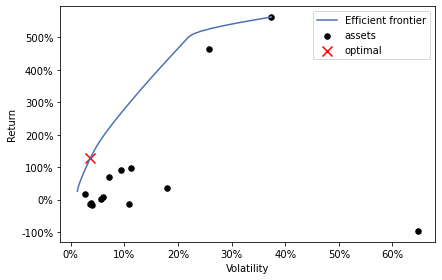

In [165]:
cl_obj = CLA(mu, Sigma)
ax = pplt.plot_efficient_frontier(cl_obj, showfig = False)
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## Creating dataframe to store trade log

In [46]:
per_trade_log=pd.DataFrame({'ATRL':[0],'bahl':[0],'EPCL':[0],'FCCL':[0],'LUCK':[0],'MCB':[0],
                             'MLCF':[0],'NETSOL':[0],'NML':[0],'OGDC':[0],'PPL':[0],'PSO':[0],
                             'SEARL':[0],'TRG':[0],'Share_Worth':[0],'Balance':[100000],'Brocker_Fee':[0],
                            'TN':[100000]})
per_trade_log.to_csv('trade_log.csv',index=None) 

In [11]:
def trader(X,nS3,share_price1,share_price2):
    Amount_Gained=((nS3*share_price2)*.1)
    Brocker_fee=((nS3*share_price2)*.1)*.3*.01
    nS3=nS3-(nS3*.1)
    X=X+Amount_Gained-Brocker_fee
    Shares_bought=(.997*Amount_Gained)/share_price1
    nS3=nS3+Shares_bought
    X=X-(.997*Amount_Gained)
    return X,nS3

In [9]:
lm=100
X=2000
tpf=98000
TN=X+tpf
df1=df[:370000]
shares1={'ATRL': 0,'bahl': 0,'EPCL': 0,'FCCL': 0,'LUCK': 0,'MCB': 0,
 'MLCF': 0,'NETSOL': 0,'NML': 0,'OGDC': 0,'PPL': 0,'PSO': 0,
 'SEARL': 0,'TRG': 0}
Min={'ATRL': 0,'bahl': 0,'EPCL': 0,'FCCL': 0,'LUCK': 0,'MCB': 0,
 'MLCF': 0,'NETSOL': 0,'NML': 0,'OGDC': 0,'PPL': 0,'PSO': 0,
 'SEARL': 0,'TRG': 0}
Max={'ATRL': 0,'bahl': 0,'EPCL': 0,'FCCL': 0,'LUCK': 0,'MCB': 0,
 'MLCF': 0,'NETSOL': 0,'NML': 0,'OGDC': 0,'PPL': 0,'PSO': 0,
 'SEARL': 0,'TRG': 0}
for share in shares1:
    shares1[share]=math.floor(7000/df1.loc[0,share])


In [30]:
for i in range(df.shape[0]//lm):
    print(tpf+X)  
    tpf,df1=0,df[i*lm:(i*lm)+lm]
    for share in shares1:
        Min[share]=df1[share].idxmin()
        Max[share]=df1[share].idxmax()
    for share in shares1:
           X,shares1[share]=trader(X,shares1[share],df.loc[Min[share],share],df.loc[Max[share],share])
           tpf+=(df.loc[(i*lm)+lm,share]*shares1[share])
    

4.842270319348757e+19
8.667952633711949e+33
8.274345821343394e+33
9.589302500614713e+33
1.0311599968538149e+34
1.0144250610616433e+34
1.1732863919799229e+34
1.2753701413722785e+34
1.4191837222968448e+34
1.3226916124873407e+34
1.2196183149089323e+34
1.3183993915318254e+34
1.2967746859476997e+34
1.2683744632232756e+34
1.2448920536107018e+34
1.0890703146879956e+34
1.1604905382890546e+34
1.2111452136347043e+34
1.1285281130677834e+34
1.1001391362391793e+34
1.0344115426573488e+34
1.1233745394827727e+34
1.077740542724083e+34
1.0256032104243138e+34
1.0271963722788704e+34
1.301575021946974e+34
1.2816896237041072e+34
1.5078049545300127e+34
1.4596592365873297e+34
1.4042048003087969e+34
1.5864588625066123e+34
1.6874613393862667e+34
1.915222924316047e+34
1.5640435930387134e+34
1.6490289397288218e+34
1.6599645767758138e+34
1.8572296756271666e+34
1.9650600472310398e+34
2.0019690899489432e+34
2.20016841846985e+34
2.5532305033530668e+34
2.4856473795787906e+34
2.420598614863363e+34
2.263129958619091e+34

2.0638643881436472e+36
2.076967435588795e+36
1.9890428555890468e+36
1.8599082090785726e+36
1.9695552882018498e+36
1.8234776575016875e+36
2.0915460397039298e+36
2.2560128757452234e+36
2.3142451560444164e+36
2.5289689563220893e+36
2.6069641831413234e+36
2.641419973566152e+36
2.825645076403009e+36
2.8958136265587667e+36
2.79964574798268e+36
2.8317939352465045e+36
2.952031760745699e+36
2.838546651908511e+36
3.1740196232777085e+36
3.3964733002961763e+36
3.484371254800162e+36
3.7744990969194745e+36
3.5975568039049006e+36
3.23869596473899e+36
3.5386930562339657e+36
3.717965278636487e+36
3.6890163233479806e+36
3.8360374673538606e+36
3.716264913649997e+36
3.68775752376537e+36
3.7361405677633106e+36
3.7283355227650797e+36
3.549568805652112e+36
3.4943110584596764e+36
3.716111622918997e+36
3.781345212008712e+36
3.766589989139951e+36
3.87150755227907e+36
3.952685063402106e+36
3.813768516479022e+36
3.918682984304062e+36
3.880339857187587e+36
3.823023315586527e+36
3.812203157164023e+36
3.713091847306

3.892644036979129e+37
3.964267170857503e+37
4.0041192880031694e+37
3.9323580541861147e+37
3.9560355895045958e+37
3.951441868223604e+37
3.9292332104181655e+37
3.7993576035516924e+37
3.8743910771385107e+37
3.8258580727679083e+37
3.938206010256016e+37
4.016602561469607e+37
4.084263028069405e+37
4.161303403854384e+37
4.189794148420186e+37
4.295638338852655e+37
4.424497847034509e+37
4.413897462165985e+37
4.391355776408388e+37
4.487321640608513e+37
4.445694535086058e+37
4.498722175756726e+37
4.474766198015627e+37
4.640960031665174e+37
4.627392215975336e+37
4.57390942548178e+37
4.464242038785603e+37
4.458150878230292e+37
4.358881454792448e+37
4.309570796161924e+37
4.2519693451893667e+37
4.206425135873643e+37
4.132873971228353e+37
4.147236946506071e+37
4.0206917261574756e+37
4.1811420130315495e+37
4.2347352591255265e+37
4.242769590178001e+37
4.270712570867297e+37
4.295387191555423e+37
4.310439429279852e+37
4.1850315103529245e+37
4.284122668439441e+37
4.256675548327301e+37
4.202506745853791e+37

4.800105697017525e+38
4.797450120734614e+38
4.806631416265174e+38
4.772868216250096e+38
4.909077323243921e+38
4.9724334604327204e+38
4.9590963667835104e+38
4.862170046042837e+38
4.975270791884531e+38
4.9062984139010584e+38
4.965790811193836e+38
4.9742300635397335e+38
4.94319977317063e+38
5.097287506184076e+38
5.119139037164825e+38
5.190100852844529e+38
5.19268102637116e+38
5.27214976555175e+38
5.2777571162835466e+38
5.2429293975223605e+38
5.269478706015577e+38
5.288579850910128e+38
5.26659101716692e+38
5.052408021962511e+38
5.302130598968884e+38
5.2952942203272154e+38
5.183066079021818e+38
5.177513816762091e+38
5.046950763792485e+38
5.0277419560893615e+38
5.097948408221758e+38
5.000020705981279e+38
5.1576097635870926e+38
5.087626184034507e+38
5.059185336797582e+38
4.903127925589454e+38
4.850217996032141e+38
4.910256693030246e+38
5.104610868392205e+38
5.03107378966406e+38
5.091084256930384e+38
4.8242843469614595e+38
4.743913565501305e+38
4.581108999017909e+38
4.8754581292210565e+38
4.87

1.0264356254678687e+39
1.0389454509933455e+39
1.0648049346123252e+39
1.0758584763692334e+39
1.0673043535502325e+39
1.0818344468342036e+39
1.0651284871799077e+39
1.0668085417135366e+39
1.0840277545814937e+39
1.089653156295549e+39
1.082186216209046e+39
1.0953681487757154e+39
1.1033650159612913e+39
1.1113432205908644e+39
1.1040275565528754e+39
1.123080884675407e+39
1.1332076363988699e+39
1.1434192049595278e+39
1.1628591700570612e+39
1.1851964270862736e+39
1.2038475050510273e+39
1.223378191703074e+39
1.2099805324395196e+39
1.2604699790352045e+39
1.2646610378014914e+39
1.2856412240965644e+39
1.291569597083223e+39
1.2832795263876339e+39
1.2659173055545253e+39
1.2736164452919552e+39
1.2997256310921083e+39
1.3099187395663526e+39
1.3047373636104796e+39
1.3063470618089528e+39
1.3306015090167613e+39
1.3286803454398356e+39
1.3309326412662024e+39
1.325638075070818e+39
1.3168432491855929e+39
1.3201993582115404e+39
1.3341675185693878e+39
1.3029951897038361e+39
1.313765866159581e+39
1.3175968784020868

2.789331938669258e+39
2.7796757612461453e+39
2.802342271843266e+39
2.8248299554911496e+39
2.8832439866352855e+39
2.858751816696659e+39
2.8982841801547225e+39
2.925914009701669e+39
2.910139499246164e+39
2.903845487101171e+39
2.8804772501690004e+39
2.936240439468265e+39
2.937404339200068e+39
2.92087163863114e+39
2.931233805167429e+39
2.956532634825264e+39
2.965126608241089e+39
2.9555033112050206e+39
2.9436981260346875e+39
2.932572904220032e+39
2.9391425281430663e+39
2.929028521390795e+39
2.899760809259737e+39
2.906968812264255e+39
2.942979531755485e+39
2.9403835054006864e+39
2.9609895707470394e+39
2.9576993677971636e+39
2.984932154274614e+39
2.974682462112011e+39
2.9978789786550273e+39
3.012674202481639e+39
3.0406428300634316e+39
3.0486222189306464e+39
3.0860132330769175e+39
3.0739053829644864e+39
3.0949582673256726e+39
3.040824108552569e+39
3.0548168011435775e+39
3.074487456962047e+39
3.0589089113903624e+39
3.0971223494324624e+39
3.0404702488404954e+39
3.01553429226616e+39
2.99250695632

6.798132379224922e+39
6.679563476722245e+39
6.555589526038434e+39
6.714078143249387e+39
6.818766848321092e+39
6.759020510467289e+39
6.53837796249672e+39
6.587710908538228e+39
6.653292811896591e+39
6.806556346340352e+39
6.873354182344517e+39
7.003457399507847e+39
7.023025806337311e+39
6.991717205205256e+39
6.981649399224646e+39
7.093754418872849e+39
7.148158512727778e+39
7.30183053100741e+39
7.321811009677422e+39
7.453194257882164e+39
7.541406908792963e+39
7.522454521582348e+39
7.433397047416603e+39
7.354232099290749e+39
7.505980718919968e+39
7.59744086218028e+39
7.565088846671939e+39
7.471450769741462e+39
7.482240414095761e+39
7.510853834351739e+39
7.592033363582267e+39
7.561983199601308e+39
7.561850470942093e+39
7.568023702528115e+39
7.611894156970602e+39
7.620048081664376e+39
7.648325032541328e+39
7.702983679711305e+39
7.60958701596875e+39
7.629506021997919e+39
7.720532933308033e+39
7.771599087483984e+39
7.805896290406391e+39
7.85683906121006e+39
7.817564766159146e+39
7.8080431291886

1.2583599022779129e+40
1.254796657635771e+40
1.2186366679633923e+40
1.1943619389059058e+40
1.2190605481914912e+40
1.190333680821534e+40
1.1754992597032385e+40
1.1882688251060672e+40
1.168208980094431e+40
1.1479703484558502e+40
1.1743418315294076e+40
1.1743805288331398e+40
1.1870428538875237e+40
1.1701816600060002e+40
1.1690819102265254e+40
1.1329802343501544e+40
1.1267993878950562e+40
1.1385755847937297e+40
1.1401407143020925e+40
1.175858751349725e+40
1.134280867917534e+40
1.1191674004408513e+40
1.136094917629312e+40
1.1513727334933895e+40
1.1464212842000464e+40
1.1594775448694485e+40
1.182613958704467e+40
1.1811264458048052e+40
1.144548128950129e+40
1.1659763367059324e+40
1.1425653456067504e+40
1.1602172915403676e+40
1.1592158672306107e+40
1.1688071198229314e+40
1.1831224080104222e+40
1.173736749665139e+40
1.1874361880085472e+40
1.2046158075625014e+40
1.217546225702115e+40
1.2121599642427722e+40
1.2337104990583843e+40
1.2452508971980025e+40
1.2366585585582997e+40
1.2496186548142972e+4

1.8608480206795883e+40
1.84692260918304e+40
1.8262921647715313e+40
1.806864681345713e+40
1.8103356943821107e+40
1.8028407032069533e+40
1.8221663169524384e+40
1.832806640473595e+40
1.799138627983657e+40
1.7310838391844343e+40
1.729893913751291e+40
1.7315060933449197e+40
1.732309104475641e+40
1.7383762121317486e+40
1.7417161839854249e+40
1.7511988514738592e+40
1.7706951228427145e+40
1.786108086989316e+40
1.789456362400656e+40
1.7684614077178665e+40
1.7710502189486893e+40
1.7341006373237418e+40
1.695892917558108e+40
1.6889503813128764e+40
1.6718700570361685e+40
1.675143709336338e+40
1.689565921378915e+40
1.7057656692962673e+40
1.627325809493684e+40
1.6214316185296353e+40
1.641255351323969e+40
1.6417108473173224e+40
1.5831236209179067e+40
1.55980116243387e+40
1.5690140104048948e+40
1.5672391514408096e+40
1.5525622645550618e+40
1.661555210789834e+40
1.6679843593700478e+40
1.6345488435291352e+40
1.6706001707744133e+40
1.7058973310276513e+40
1.7139075889895423e+40
1.7548462470308374e+40
1.741

2.372125798265345e+40
2.3982798251094136e+40
2.4008533426712086e+40
2.4618859461349214e+40
2.4903592069673166e+40
2.522055822733343e+40
2.5661371656566713e+40
2.556416929553615e+40
2.593168855732267e+40
2.6391492103130336e+40
2.68461104303601e+40
2.7063105948948476e+40
2.7335226975895207e+40
2.783311818490191e+40
2.834278715943822e+40
2.800023574360101e+40
2.8385664686547767e+40
2.8367651068583266e+40
2.833945071264087e+40
2.8651365189292843e+40
2.868053039563898e+40
2.913353484892312e+40
2.892178279027387e+40
2.9384195561944398e+40
2.9031953171322287e+40
2.9221665202339944e+40
2.915626137817923e+40
2.954089000364593e+40
2.997463612890683e+40
3.0107542803384825e+40
2.974455469460899e+40
2.9516316077706947e+40
2.8949343387717965e+40
2.798729748023254e+40
2.7818912803198873e+40
2.7906367626328087e+40
2.76620466838167e+40
2.8912637709320144e+40
2.9950037672822274e+40
3.007245146569368e+40
2.9600391433674266e+40
3.0155419863651493e+40
3.014175682184067e+40
3.0283464622900264e+40
3.07852178

5.889743574976544e+40
5.949713432160475e+40
6.0886927278421555e+40
5.928966021974955e+40
5.993857623089268e+40
6.051976977746469e+40
6.13088538513009e+40
6.147138558651172e+40
6.045154200298699e+40
5.99847875421639e+40
5.960786120912278e+40
5.85113017820604e+40
5.824410875543955e+40
5.620008180731996e+40
5.570586822631334e+40
5.670264406830589e+40
5.81640227940372e+40
5.8096541041008535e+40
5.945005693337444e+40
6.030612156685404e+40
5.89500508796267e+40
5.943283177071339e+40
5.9022924347147645e+40
5.892380193292227e+40
5.844519196929839e+40
5.995009138262806e+40
5.951102153669695e+40
5.830906363824246e+40
5.67311027262663e+40
5.608093102123595e+40
5.641162714692945e+40
5.793177461485504e+40
5.813900944623515e+40
5.71986432949251e+40
5.583324762651825e+40
5.523070467476356e+40
5.525532203053278e+40
5.574896079260851e+40
5.611417074404681e+40
5.681490215230145e+40
5.741192190098703e+40
5.780996884915651e+40
5.906238122738307e+40
5.649161708798818e+40
5.650301239159078e+40
5.624095230778

1.2677800368992031e+41
1.2631622095406345e+41
1.266362612661507e+41
1.2814672956407732e+41
1.3053591117733845e+41
1.348765507548064e+41
1.3635895529500564e+41
1.3755356144253112e+41
1.3213641796421063e+41
1.3318162104392932e+41
1.3627466472650398e+41
1.382194692882021e+41
1.4106785161202867e+41
1.4018419784429491e+41
1.4075952632959579e+41
1.4043767503758303e+41
1.4082410496155701e+41
1.4338521203706018e+41
1.4512744720212309e+41
1.442096812050686e+41
1.4407718404922605e+41
1.4625054596404115e+41
1.4445256026730587e+41
1.467783600279634e+41
1.4892697425771616e+41
1.4789329092915232e+41
1.4604858027386271e+41
1.4603051666991512e+41
1.465467419865244e+41
1.4684516228637278e+41
1.4786593640104516e+41
1.4406062424593488e+41
1.4068031484879662e+41
1.4243864304070013e+41
1.4855283041123452e+41
1.5061665666893909e+41
1.4838960973953728e+41
1.4988439828545293e+41
1.5061876296083929e+41
1.5058790112810074e+41
1.4918232360784001e+41
1.4757971351393378e+41
1.4847753611151807e+41
1.453791908134033

1.2904953511679416e+41
1.2901082025598121e+41
1.2897211700999306e+41
1.2893342537546459e+41
1.2889474534767498e+41
1.2885607692474889e+41
1.288174201017849e+41
1.28778774876216e+41
1.2874014124396328e+41
1.2870151920149196e+41
1.2866290874546099e+41
1.2862430987271745e+41
1.2858572257926126e+41
1.285471468626885e+41
1.2850858271871664e+41
1.2847003014338727e+41
1.2843148913376823e+41
1.2839295968689824e+41
1.283544417995716e+41
1.2831593546690827e+41
1.2827744068633104e+41
1.282389574537756e+41
1.2820048576622492e+41
1.2816202562046787e+41
1.281235770130146e+41
1.2808513994083016e+41
1.2804671439891048e+41
1.280083003838848e+41
1.2796989789455735e+41
1.2793150692588455e+41
1.2789312747390983e+41
1.2785475953530452e+41
1.2781640310687676e+41
1.277780581858012e+41
1.2773972476843497e+41
1.2770140285142121e+41
1.2766309243162523e+41
1.2762479350408565e+41
1.2758650606640959e+41
1.2754823011584568e+41
1.2750996564680444e+41
1.2747171265746888e+41
1.2743347114348751e+41
1.2739524110148598e+

1.1418020663686182e+41
1.1414595257449772e+41
1.1411170878856223e+41
1.1407747527550851e+41
1.140432520332702e+41
1.1400903905740672e+41
1.1397483634607286e+41
1.139406438950943e+41
1.1390646170150789e+41
1.1387228976324899e+41
1.1383812807690874e+41
1.138039766402872e+41
1.1376983544723005e+41
1.137357044963618e+41
1.1370158378465999e+41
1.1366747330895742e+41
1.136333730664738e+41
1.1359928305501693e+41
1.1356520327003243e+41
1.1353113370907385e+41
1.1349707436897785e+41
1.1346302524684245e+41
1.1342898633954065e+41
1.1339495764359451e+41
1.1336093915612197e+41
1.1332693087379196e+41
1.1329293279466783e+41
1.132589449142371e+41
1.1322496723038454e+41
1.131909997393185e+41
1.1315704244033488e+41
1.131230953284761e+41
1.1308915839959033e+41
1.1305523165113904e+41
1.1302131508050845e+41
1.129874086867937e+41
1.1295351246526276e+41
1.1291962641115557e+41
1.1288575052454915e+41
1.128518848016417e+41
1.1281802923729074e+41


KeyError: 537800

In [25]:
for share in shares1:
    tpf+=(df.loc[(5376*lm)+lm,share]*shares1[share])
tpf

1.2640115757165442e+17